# First Foray

DS 5001 Text as Data

## Purpose

We take a raw text file from Project Gutenberg and convert it into a dataframe of tokens. 

We then explore some properties of the data. 

The main idea is to get acquainted with the primary process of convert text into analytical form.

## Set Up

In [1]:
import pandas as pd
import configparser

In [2]:
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

## Import File

In [3]:
!ls -l {data_home}

total 912
drwx------@ 8 jamessiegener  staff     256 Jan 23 16:24 gutenberg
-rw-r--r--@ 1 jamessiegener  staff  465627 Jan 20 22:31 pg42324.txt


In [4]:
src_file = f"{data_home}/gutenberg/pg105.txt"

In [5]:
lines = open(src_file, 'r').readlines()

In [6]:
lines[:5]

['The Project Gutenberg EBook of Persuasion, by Jane Austen\n',
 '\n',
 'This eBook is for the use of anyone anywhere at no cost and with\n',
 'almost no restrictions whatsoever.  You may copy it, give it away or\n',
 're-use it under the terms of the Project Gutenberg License included\n']

In [7]:
lines[-5:]

['\n',
 'This Web site includes information about Project Gutenberg-tm,\n',
 'including how to make donations to the Project Gutenberg Literary\n',
 'Archive Foundation, how to help produce our new eBooks, and how to\n',
 'subscribe to our email newsletter to hear about new eBooks.\n']

## Convert to Dataframe

In [8]:
text = pd.DataFrame(lines)

In [9]:
text

,0
0,"The Project Gutenberg EBook of Persuasion, by ..."
1,\n
2,This eBook is for the use of anyone anywhere a...
3,almost no restrictions whatsoever. You may co...
4,re-use it under the terms of the Project Guten...
...,...
8729,\n
8730,This Web site includes information about Proje...
8731,including how to make donations to the Project...
8732,"Archive Foundation, how to help produce our ne..."


In [10]:
text.sample(10)

,0
7766,but make you comprehend what a man suffers whe...
5297,Henrietta did not remain at Lyme as long as Lo...
3139,\n
94,in society. He considered the blessing of bea...
5996,\n
6006,"""Indeed! I should not have supposed that you ..."
6487,"having this claim on Mr Elliot, I should be ex..."
4853,"their value. Anne smiled and said,\n"
3317,"Anne and Henrietta, finding themselves the ear..."
8430,entity to whom you paid the fee as set forth i...


In [11]:
text.columns = ['line_str']

In [12]:
text.head()

,line_str
0,"The Project Gutenberg EBook of Persuasion, by ..."
1,\n
2,This eBook is for the use of anyone anywhere a...
3,almost no restrictions whatsoever. You may co...
4,re-use it under the terms of the Project Guten...


In [13]:
text.index.name = 'line_num'

In [14]:
text.head()

,line_str
line_num,
0,"The Project Gutenberg EBook of Persuasion, by ..."
1,\n
2,This eBook is for the use of anyone anywhere a...
3,almost no restrictions whatsoever. You may co...
4,re-use it under the terms of the Project Guten...


## Extract Simple Features

In [15]:
text['len'] = text.line_str.str.len()

In [16]:
text.len.describe()

count    8734.000000
mean       55.673460
std        25.340378
min         1.000000
25%        61.000000
50%        68.000000
75%        71.000000
max        74.000000
Name: len, dtype: float64

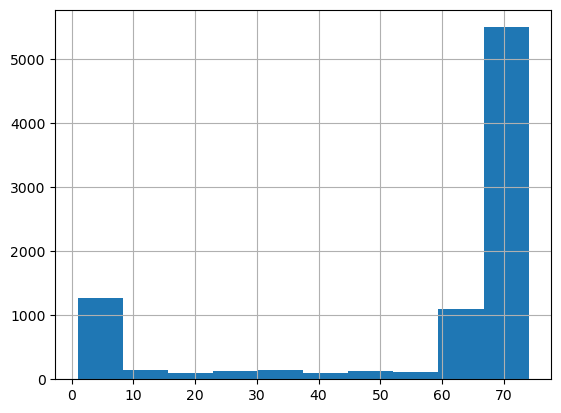

In [17]:
text.len.hist();

**Why two humps?** What might this bimodal distribution indicate?

Let's look at the first hump for characters.

In [18]:
text[text['len'] < 5].sample(10)

,line_str,len
line_num,,
6648,\n,1
8367,\n,1
6969,\n,1
2454,\n,1
2654,\n,1
1624,\n,1
787,\n,1
7437,\n,1
5329,\n,1


## Import Again

Now that we know what line breaks mean, we can use this information to import the file with a more accurate structure. 

Note also that we could have inferred this from visual inspection, too. 

But the principle that statistical features can provide evidence for structure remains -- we will use this throughout the course.

### Interpret line breaks `\n\n`

In [19]:
chunk_pat = '\n\n'

In [20]:
chunks = open(src_file, 'r').read().split(chunk_pat)

In [21]:
chunks[:5]

['The Project Gutenberg EBook of Persuasion, by Jane Austen',
 'This eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.net',
 '\nTitle: Persuasion',
 'Author: Jane Austen',
 'Release Date: June 5, 2008 [EBook #105]\nLast Updated: February 15, 2015']

In [22]:
text = pd.DataFrame(chunks, columns=['chunk_str'])
text.index.name = 'chunk_id'

In [23]:
text.head()

,chunk_str
chunk_id,
0,"The Project Gutenberg EBook of Persuasion, by ..."
1,This eBook is for the use of anyone anywhere a...
2,\nTitle: Persuasion
3,Author: Jane Austen
4,"Release Date: June 5, 2008 [EBook #105]\nLast ..."


In [24]:
text.shape

(1132, 1)

### Remove remaining breaks

In [25]:
text.chunk_str = text.chunk_str.str.replace('\n+', ' ', regex=True).str.strip()

In [26]:
text.head()

,chunk_str
chunk_id,
0,"The Project Gutenberg EBook of Persuasion, by ..."
1,This eBook is for the use of anyone anywhere a...
2,Title: Persuasion
3,Author: Jane Austen
4,"Release Date: June 5, 2008 [EBook #105] Last U..."


## Convert Lines to Tokens

`K`: A dataframe of tokens.

Note the `expand` argument to the `.split()` method.

In [27]:
K = text.chunk_str.str.split(expand=True).stack().to_frame('token_str')
K.index.names = ['chunk_num','token_num']

In [28]:
K

token_str
chunk_num token_num           
0         0                The
          1            Project
          2          Gutenberg
          3              EBook
          4                 of
...                        ...
1131      35                to
          36              hear
          37             about
          38               new
          39           eBooks.

[86307 rows x 1 columns]

Broken down into steps

In [29]:
# text.chunk_str.str.split()

In [30]:
# text.chunk_str.str.split(expand=True)

In [31]:
# text.chunk_str.str.split(expand=True).stack()

In [32]:
# text.chunk_str.str.split(expand=True).stack().to_frame('token_str')

In [33]:
K.iloc[100:120]

token_str
chunk_num token_num                
19        0                     Sir
          1                  Walter
          2                 Elliot,
          3                      of
          4                Kellynch
          5                   Hall,
          6                      in
          7          Somersetshire,
          8                     was
          9                       a
          10                    man
          11                   who,
          12                    for
          13                    his
          14                    own
          15             amusement,
          16                  never
          17                   took
          18                     up
          19                    any

## Do Some Cleaning

In [34]:
K['term_str'] = K.token_str.str.replace(r'\W+', '', regex=True).str.lower()

In [35]:
K.sample(10)

,,token_str,term_str
chunk_num,token_num,,
41,0,Their,their
848,16,great,great
674,18,Perhaps,perhaps
983,43,think,think
271,79,collected,collected
854,33,them,them
435,57,him,him
84,6,observed,observed
379,40,might,might


## Extract a Vocabulary

`V`: A table of terms. As opposed to tokens, which are term _instances_.

**Terms** are symbol **types**.

**Tokens** are symbol **instances**.

In [36]:
V = K.term_str.value_counts().to_frame('n')
V.index.name = 'term_str'

In [37]:
V.head(10)

,n
term_str,
the,3501
to,2862
and,2851
of,2684
a,1648
in,1439
was,1336
her,1202
had,1187


Define relative frequency, an estimate of the probability of the word.

In [38]:
V['p'] = V.n / V.n.sum()

In [39]:
V

,n,p
term_str,,
the,3501,0.040564
to,2862,0.033161
and,2851,0.033033
of,2684,0.031098
a,1648,0.019095
...,...,...
owners,1,0.000012
convictions,1,0.000012
precluded,1,0.000012


## Visualize Frequent Words

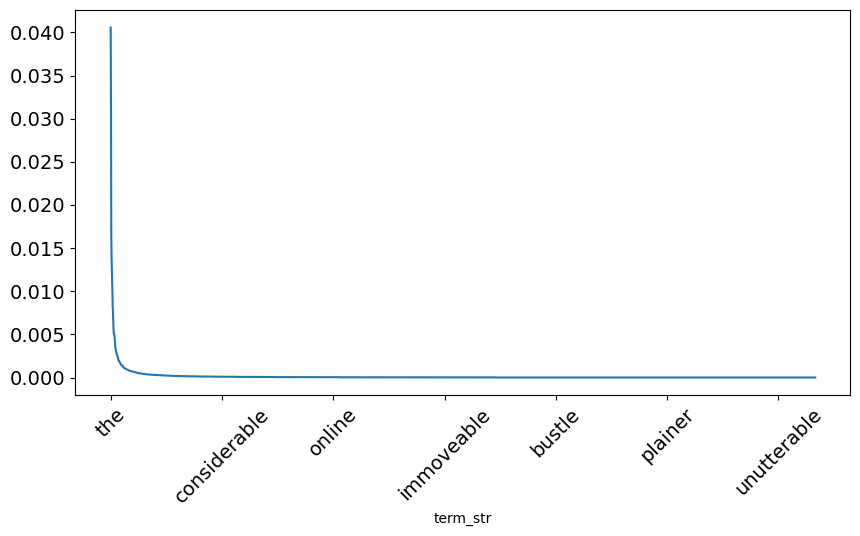

In [40]:
V.p.plot(figsize=(10,5), fontsize=14, rot=45, legend=False);

In [41]:
# V.p.plot(figsize=(10,5), fontsize=14, rot=45, legend=False, logy=True);

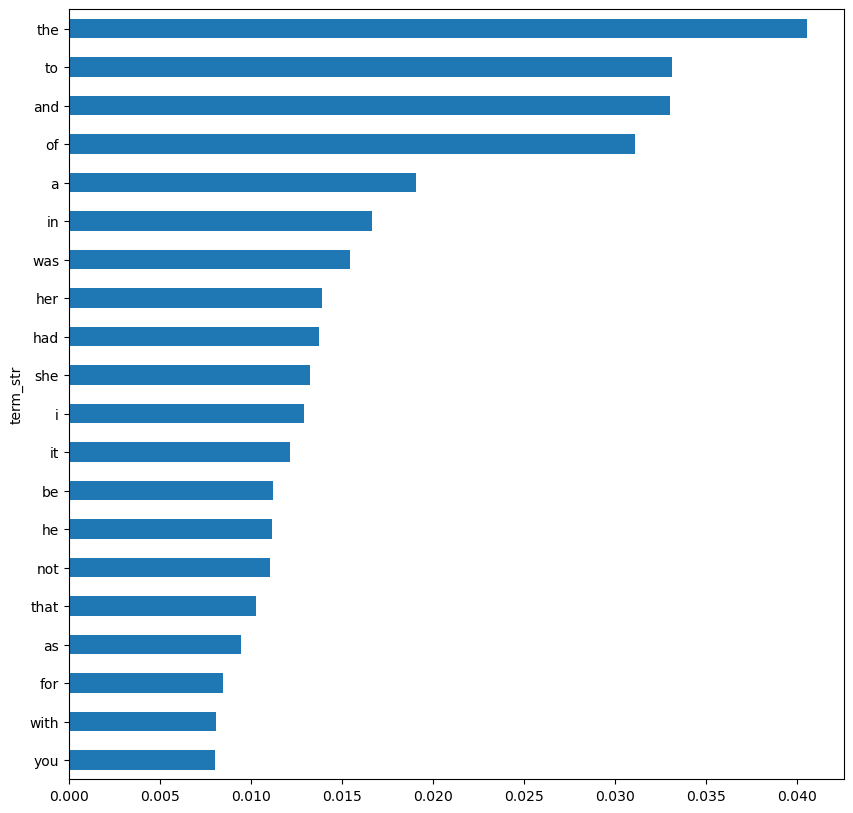

In [44]:
V.p.head(20).sort_values().plot.barh(figsize=(10,10));

## Save Work

In [43]:
K.to_csv(f"{output_dir}/M01-ff-TOKENS.csv")
V.to_csv(f"{output_dir}/M01-ff-VOCAB.csv")

## The The

Why is "the" the most frequent word?

Consider that "the" is "[The Most Powerful Word in the English Language](http://www.bbc.com/culture/story/20200109-is-this-the-most-powerful-word-in-the-english-language)."

> ... ‘the’ lies at the heart of English grammar, having a function rather than a meaning. Words are split into two categories: expressions with a semantic meaning and functional words like ‘the’, ‘to’, ‘for’, with a job to do. ‘The’ can function in multiple ways. This is typical, explains Gary Thoms, assistant professor in linguistics at New York University: “a super high-usage word will often develop a real flexibility”, with different subtle uses that make it hard to define. Helping us understand what is being referred to, ‘the’ makes sense of nouns as a subject or an object. So even someone with a rudimentary grasp of English can tell the difference between ‘I ate an apple’ and ‘I ate the apple’.

Note: function vs. meaning ...

> **Function words are very specific to each language.**<br/><br/>
So, someone who is a native Hindi or Russian speaker is going to have to think very differently when constructing a sentence in English. Murphy says that she has noticed, for instance, that sometimes her Chinese students hedge their bets and include ‘the’ where it is not required. Conversely, Smith describes Russian friends who are so unsure when to use ‘the’ that they sometimes leave a little pause: ‘I went into... bank. I picked up... pen.’ English speakers learning a language with no equivalent of ‘the’ also struggle and might overcompensate by using words like ‘this’ and ‘that’ instead.